In [1]:
import pickle
import cv2
import ipywidgets as widgets
from IPython.display import display
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from skimage import exposure
from skimage.metrics import structural_similarity as ssim

Import datasets

In [2]:
# Load sample data 

with open('data_git/post_sample.pkl', 'rb') as file:
    post_ct_df_list = pickle.load(file)
    
with open('data_git/pre_sample.pkl', 'rb') as file:
    pre_ct_df_list = pickle.load(file)
    
with open('data_git/segment_sample.pkl', 'rb') as file:
    segmentation_df_list = pickle.load(file)

Load display functions

In [3]:
# Example display patient

i = 1

df = segmentation_df_list[i]
    
df_ct = pre_ct_df_list[i]
    
df_ct2 = post_ct_df_list[i]


In [4]:


def display_image(i, j):
    
    # Get the UID code from the pre treatment CT scan 
    
    uid_code = df_ct['UID'].iloc[i]
    
    # Find corresponding segmentations (one for each label)

    segmentations = df[df['UID'] == uid_code]

    f, axarr = plt.subplots(1,2, figsize=(10, 14))
    axarr[0].imshow(df_ct['pixel_array'].iloc[i], cmap=plt.cm.bone)
    axarr[1].imshow(df_ct2['pixel_array'].iloc[j], cmap=plt.cm.bone)

    color_list = ['red', 'green', 'blue', 'yellow']
    labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta"]
    patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, color_list)]
    plt.legend(handles=patches, bbox_to_anchor=(1.8, 1))

    if len(segmentations) > 0:
        for segment in segmentations.iterrows():
            liver_mask = np.where(segment[1]['pixel_array'] != 0, segment[1]['label'], 0)
            liver_mask = np.ma.masked_where(liver_mask == 0, liver_mask)
            axarr[0].imshow(liver_mask, cmap=ListedColormap(color_list[segment[1]['label']-1]), alpha=0.5)



In [5]:
def dashboard_display(i):
    
    df = segmentation_df_list[i]
    
    df_ct = pre_ct_df_list[i]
    
    df_ct2 = post_ct_df_list[i]
    
    slider1 = widgets.IntSlider(min=0, max=len(df_ct)-1, step=1, value=0)
    slider2 = widgets.IntSlider(min=0, max=len(df_ct2)-1, step=1, value=0)
    widgets.interact(display_image, i=slider1, j=slider2)

In [6]:
# Example display of patient
dashboard_display(1)

interactive(children=(IntSlider(value=0, description='i', max=72), IntSlider(value=0, description='j', max=80)…

Search section with most visible cancer mass

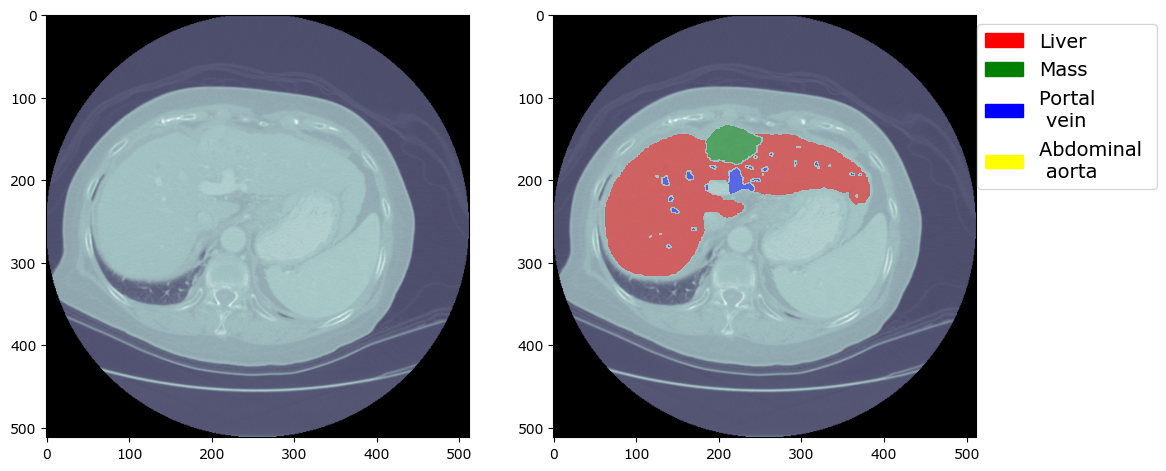

In [7]:

# Function to search for section with most visible tumor mass

def plot_max_cancer_mass_section(index, plot = False):
    
    df = segmentation_df_list[index]
    
    # Label 2 is cancer mass in the file format 

    df_label_2 = df[df['label'] == 2]
    
    # Look for the image with the largest cancer mass (pixel count)
    
    max_val_index = df_label_2['pixel_array'].apply(np.sum).idxmax()
    max_val_row = df_label_2.loc[max_val_index]

    
    pre_tumor_size = max_val_row['pixel_array'].sum()
    
    #print(f"Initial tumor size: {pre_tumor_size} pixels")

    pre_df = pre_ct_df_list[index]

    if np.sum(pre_df['UID'] == max_val_row['UID']) > 0:
        p_array = pre_df[pre_df['UID'] == max_val_row['UID']]['pixel_array']
        reference_ct = pre_df[pre_df['UID'] == max_val_row['UID']]
        
        
        if plot:
        
            f, axarr = plt.subplots(1,2, figsize=(12, 18))
            
            # Plot original image
            axarr[0].imshow(p_array.values[0], cmap='bone')
            
            # Plot image with mask
            color_list = ['red', 'green', 'blue', 'yellow']
            labels = ["Liver", "Mass", "Portal \n vein", "Abdominal \n aorta"]
            patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, color_list)]
            plt.legend(handles=patches, bbox_to_anchor=(1.45, 1), fontsize = 14)

            segmentations = df[df['UID'] == max_val_row['UID']]
            axarr[1].imshow(p_array.values[0], cmap='bone')
            if len(segmentations) > 0:
                for segment in segmentations.iterrows():
                    liver_mask = np.where(segment[1]['pixel_array'] != 0, segment[1]['label'], 0)
                    liver_mask = np.ma.masked_where(liver_mask == 0, liver_mask)
                    axarr[1].imshow(liver_mask, cmap=ListedColormap(color_list[segment[1]['label']-1]), alpha=0.5)
        
        plt.show()
        return reference_ct, max_val_row, pre_tumor_size
    

# Call the function with the desired index
try:
    reference_ct, pre_segment, pre_tumor_size = plot_max_cancer_mass_section(1,1)
except:
    print("No corresponding image found")


In [8]:
segmentation_parray_list = []
pre_parray_list = []
initial_tumor_size_list = []
ind_max_tumor_size_list = []


for i in range(len(pre_ct_df_list)):
    try:
        reference_ct, pre_segment, pre_tumor_size = plot_max_cancer_mass_section(i)
        segmentation_parray_list.append(pre_segment['pixel_array'])
        pre_parray_list.append(reference_ct['pixel_array'])
        initial_tumor_size_list.append(pre_tumor_size)
        ind_max_tumor_size_list.append(i)
    except:
        print(f"No corresponding image found for index {i}")

In [9]:

# Adaptive histogram equalization

pre_parray_list = [item.values[0] for item in pre_parray_list]
pre_parray_list = [exposure.equalize_adapthist(item) for item in pre_parray_list]

In [10]:


def find_closest_image(reference_img, dataset):
    # Initialize variables to store the closest image index and similarity score
    closest_image_idx = None
    max_similarity = -1

    # Iterate over images in the dataset
    for idx, img in enumerate(dataset):
        # Calculate Structural Similarity Index (SSIM)
        similarity = ssim(reference_img, img, data_range=reference_img.max() - reference_img.min())

        # Update closest image 
        if similarity > max_similarity:
            max_similarity = similarity
            closest_image_idx = idx

    return closest_image_idx


In [11]:
post_parray_list = []

for i, ind in enumerate(ind_max_tumor_size_list):
    
    # Get section corresponding to most visible tumor
    reference_img = pre_parray_list[i]
    
    # Apply adaptive histogram equalization to post tratment scan 
    dataset = [exposure.equalize_adapthist(item) for item in post_ct_df_list[ind]['pixel_array']]
    
    # Find closest image in the post treatment scan
    closest_image_idx = find_closest_image(reference_img, dataset)
    
    # 
    post_parray_list.append(dataset[closest_image_idx])
    

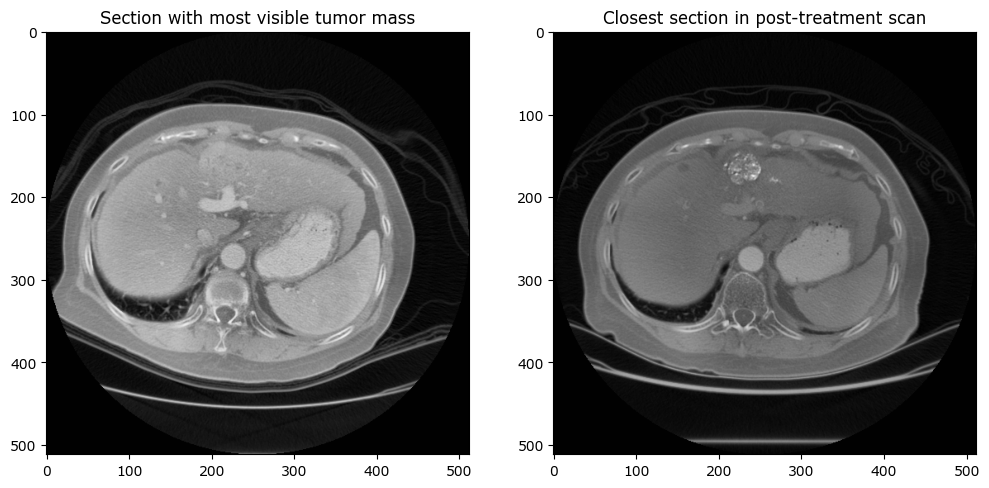

In [12]:
# Example for patient 26 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pre_parray_list[1], cmap='gray')
plt.title('Section with most visible tumor mass')

plt.subplot(1, 2, 2)
plt.imshow(post_parray_list[1], cmap='gray')
plt.title('Closest section in post-treatment scan')

plt.show()


In [13]:


def expand_bounding_box(mask, margin):
    # Find contours of the tumor mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate bounding box of the contours
    x, y, w, h = cv2.boundingRect(contours[0])  # Assuming only one contour
    
    # Expand bounding box by adding margin
    x -= margin
    y -= margin
    w += 2 * margin
    h += 2 * margin
    
    # Create expanded bounding box image
    expanded_bbox = np.zeros_like(mask)
    expanded_bbox[y:y+h, x:x+w] = 255  # Set the expanded region to white
    
    # Plot contours
    original_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    tumor_contour = np.zeros(mask.shape, np.uint8)
    cv2.drawContours(tumor_contour, contours, -1, (255),5)
    
    tumor_mask = np.ma.masked_where(tumor_contour == 0, tumor_contour)
    
    window = np.zeros(mask.shape, np.uint8)
    cv2.rectangle(window, (x, y), (x + w, y + h), (255, 0, 0), 5)
    #window_mask = np.ma.masked_where(window == 0, window)
    

    cv2.drawContours(original_image, contours, -1, (0, 255, 0), 2)  # Original contours
    cv2.rectangle(original_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Bounding box
    #cv2.rectangle(original_image, (x - margin, y - margin), (x + w + margin, y + h + margin), (0, 0, 255), 2)  # Expanded bounding box
    
    return expanded_bbox, original_image, tumor_mask, window ,x, y, w, h



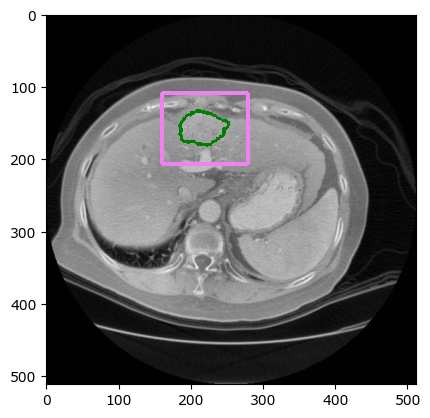

In [14]:
# Example 

margin = 25 # Window margin

sample_section = segmentation_parray_list[1]

expanded_bbox, contour_image, tumor_contour, window, x, y, w, h= expand_bounding_box(sample_section, margin)

# Display the expanded bounding box

plt.imshow(pre_parray_list[1], cmap = 'gray')

# Display tumor contour
#liver_mask = np.ma.masked_where(tumor_contour == 0, tumor_contour)
plt.imshow(tumor_contour, cmap = ListedColormap('green'))

# Display region of interest contour
window_mask = np.ma.masked_where(window == 0, window)
plt.imshow(window_mask, cmap = ListedColormap('violet'))

Pre-treatment tumor contour and window 

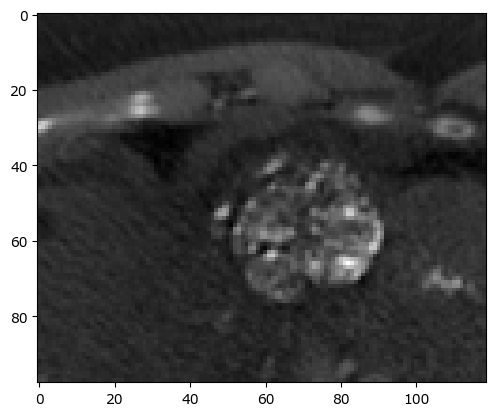

In [15]:
# Corresponding section in the post treatment scan 

plt.imshow(post_parray_list[1][y:y+h, x:x+w], cmap='gray')

(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

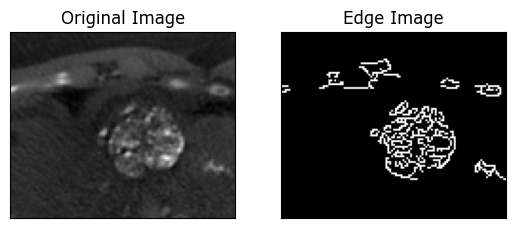

In [16]:
## Finding contours to detect texture

region_of_interest2 = post_parray_list[1][y:y+h, x:x+w]

region_of_interest = (region_of_interest2 * 255).astype(np.uint8)
img = region_of_interest
# clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(6,6))
# img = clahe.apply(img)
# region_of_interest = post_parray_list[1][y:y+h, x:x+w]

edges = cv2.Canny(region_of_interest, 50, 200)
plt.subplot(121),plt.imshow(img,cmap = 'grey')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def get_max_contour_area(region_of_interest):
    # Read the grayscale image (already in region_of_interest)
    edges = cv2.Canny(region_of_interest, 50, 200)  # Apply Canny edge detection

    # Perform morphological dilation to group nearby edges
    kernel = np.ones((2, 2), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours in the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask to visualize the largest contour
    mask = np.zeros_like(region_of_interest)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Visualize the segmented region with the largest concentration of edges
    plt.figure(figsize=(10, 5))
    plt.imshow(mask, cmap='gray')
    plt.title('Segmented Region with the Largest Concentration of Edges')
    plt.axis('off')
    plt.show()


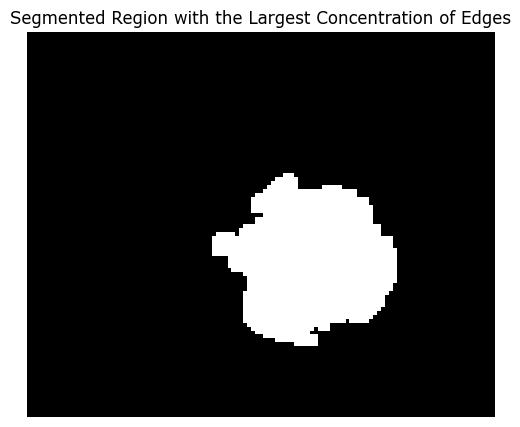

In [18]:
get_max_contour_area(region_of_interest)

In [19]:

# Plot and comparison of tumor size

def plot_tumor_comparison(closest_img, region_of_interest,  pre_scan, pre_segment):
    
    def calculate_tumor_size_change(mask1, mask2):
        # Count the number of non-zero pixels in each mask
        non_zero_pixels_mask1 = np.count_nonzero(mask1)
        non_zero_pixels_mask2 = np.count_nonzero(mask2)

        # Calculate the percentage difference
        percentage_difference = (non_zero_pixels_mask2 - non_zero_pixels_mask1) / non_zero_pixels_mask1 * 100

        return percentage_difference
    
    # Read the grayscale image (already in region_of_interest)
    edges = cv2.Canny(region_of_interest, 50, 200)  # Apply Canny edge detection

    # Perform morphological dilation to group nearby edges
    kernel = np.ones((2, 2), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours in the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask to visualize the largest contour
    mask = np.zeros_like(region_of_interest, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Create a zero-filled array with the same dimensions as the original image
    overlay_img = np.zeros_like(closest_img)

    # Place the mask within the corresponding region of the zero-filled array
    # Assume you have the bounding rectangle coordinates
    overlay_img[y:y+h, x:x+w] = mask

    # Overlay the mask on the grayscale image
    overlayed_image = cv2.addWeighted(closest_img, 0.9, overlay_img, 0.5, 0)

    # Visualize the original image with the tumor segmentation

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(pre_scan, cmap='gray')
    plt.title('Original Image (pre-treatment)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pre_scan, cmap='gray')
    #plt.imshow(liver_mask, alpha = 0.5, cmap='viridis')
    plt.title('Segmentation Overlay (pre-treatment)')
    plt.axis('off')

    liver_mask_1 = np.where(pre_segment != 0, 1, 0)
    liver_mask_1 = np.ma.masked_where(liver_mask_1 == 0, liver_mask_1)

    plt.imshow(liver_mask_1, alpha=0.5, cmap = ListedColormap(['green']))


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(closest_img, cmap='gray')
    plt.title('Original Image (post-treatment)')
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(closest_img, cmap='gray')
    plt.title('Segmentation Overlay (post-treatment)')
    plt.axis('off')


    liver_mask_2 = np.where(overlay_img != 0, 1, 0)
    liver_mask_2 = np.ma.masked_where(liver_mask_2 == 0, liver_mask_2)

    plt.imshow(liver_mask_2,alpha=0.5, cmap = ListedColormap(['green']))
    
    plt.show()
    
    # Change in size percentage (pixel count) 
    
    percentage_difference = calculate_tumor_size_change(liver_mask_1, liver_mask_2)
   
    print("The difference in tumor size is {:.2f}%".format(percentage_difference))
    
    return liver_mask_2, percentage_difference


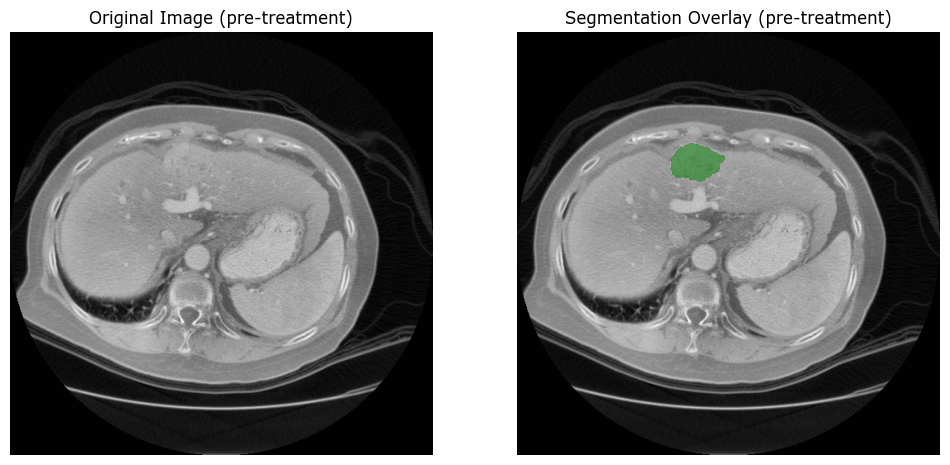

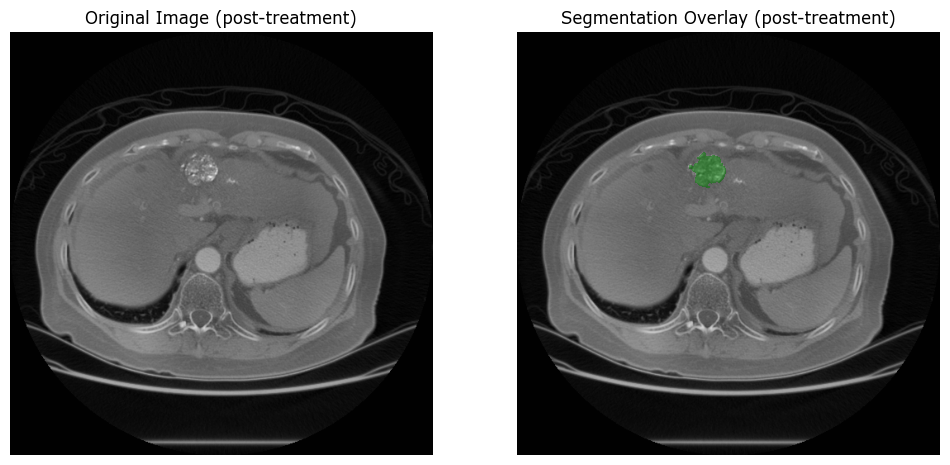

The difference in tumor size is -42.42%


In [20]:
# Example for tumor comparison

closest_img = post_parray_list[1]
pre_scan = pre_parray_list[1]
pre_segment = segmentation_parray_list[1]

_, _ = plot_tumor_comparison(closest_img, region_of_interest, pre_scan, pre_segment)

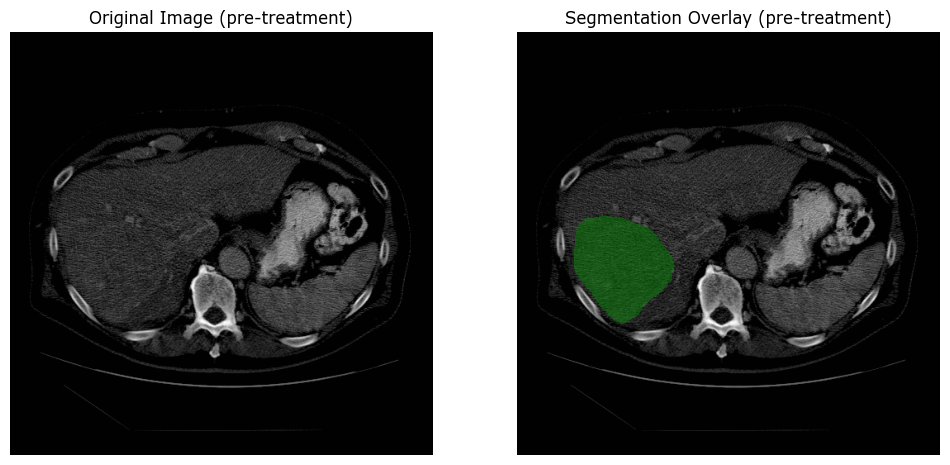

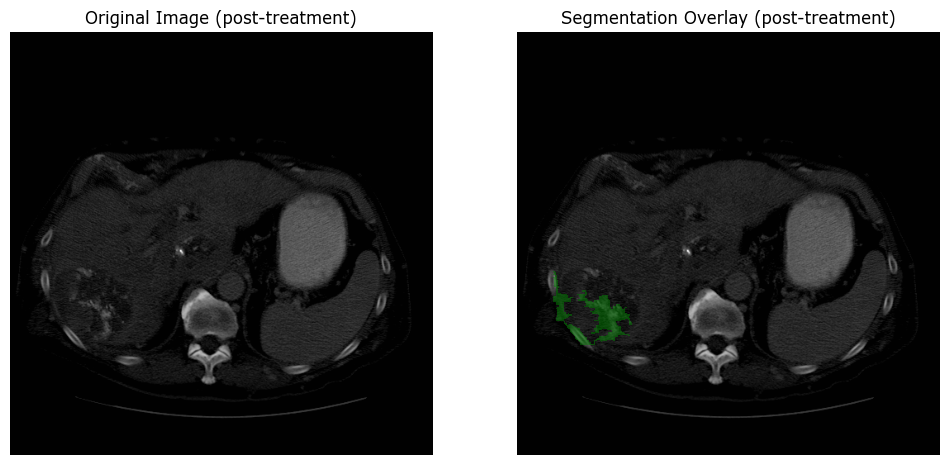

The difference in tumor size is -73.00%


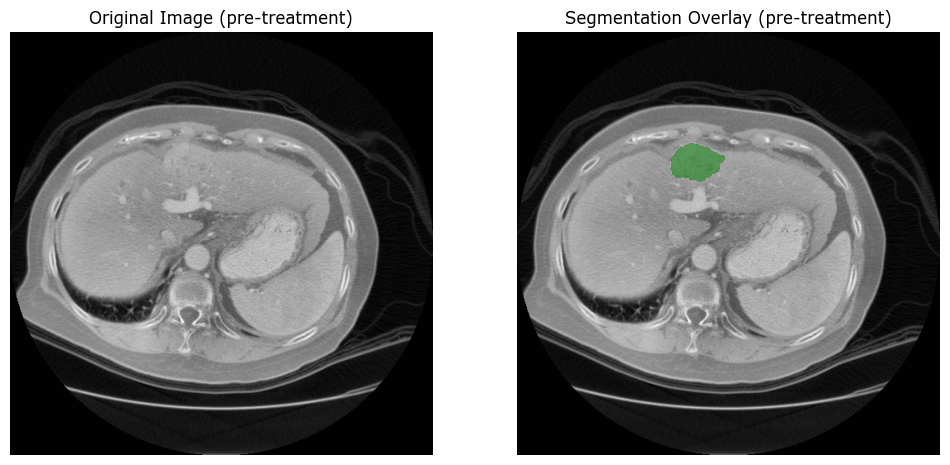

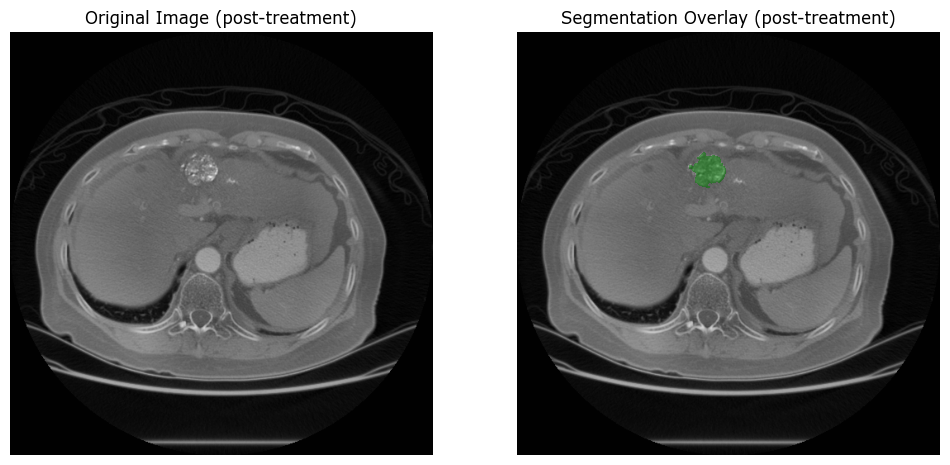

The difference in tumor size is -42.42%


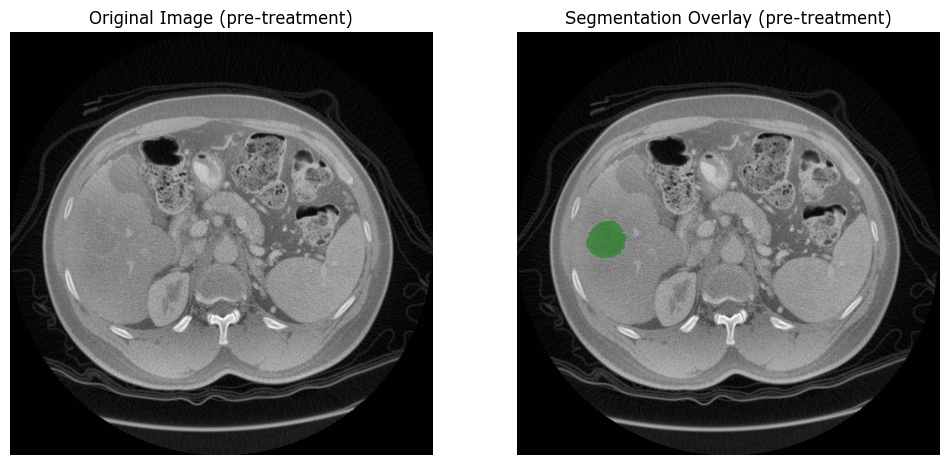

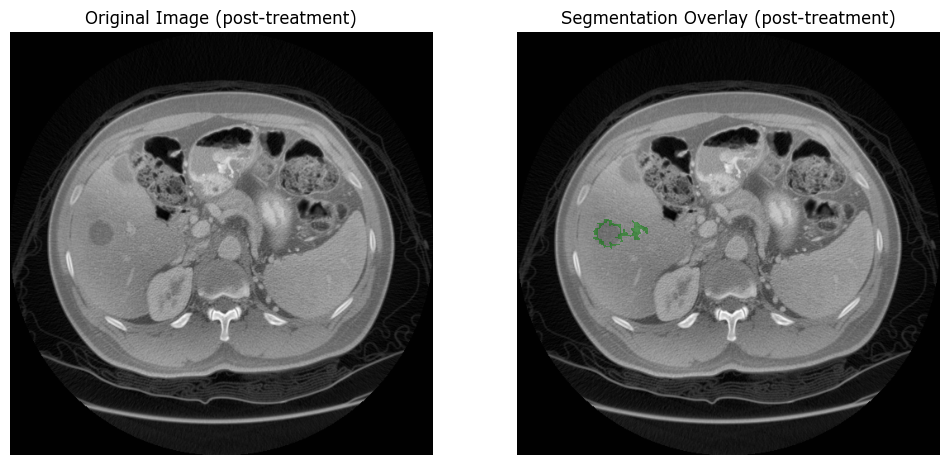

The difference in tumor size is -49.42%


In [21]:
## Global dataset 


for i in range(len(pre_parray_list)):
    
    # Get zones of interest
    
    _, _, tumor_contour, window, x, y, w, h= expand_bounding_box(segmentation_parray_list[i], margin)

    region_of_interest = (post_parray_list[i][y:y+h, x:x+w] * 255).astype(np.uint8)
    
    # Plot and compare tumor size
    
    plot_tumor_comparison(post_parray_list[i], region_of_interest, 
                          pre_parray_list[i], segmentation_parray_list[i])
    
    